<a href="https://colab.research.google.com/github/Teghfo/BootCampTabestan99/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6 MB 1.5 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 367 kB 50.1 MB/s 
     |████████████████████████████████| 3.2 MB 39.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you

In [2]:
import numpy as np
import gym
import tensorflow as tf
print("gym version: ", gym.__version__)
print("tf version: ", tf.__version__)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

gym version:  0.17.3
tf version:  1.13.1


In [3]:

env_name = "CartPole-v1"
env = gym.make(env_name)
print("dimension of state space: ", env.observation_space.shape)
print("dimension of action space: ", env.action_space.n)


dimension of state space:  (4,)
dimension of action space:  2


In [4]:
from tensorflow.python.ops.math_ops import reduce_sum
class DQN:
  def __init__(self, state_dim, action_numbers):
    print([*state_dim])
    self.input_state = tf.placeholder(tf.float32, shape=[None, *state_dim])
    self.input_action = tf.placeholder(tf.int32, shape=[None])
    self.target = tf.placeholder(tf.float32, shape=[None])  # r + gamma * max(Q)
    self.one_hot_action = tf.one_hot(self.input_action, depth=action_numbers)

    self.hidden_layer = tf.layers.Dense(128, activation=tf.nn.relu)(self.input_state)
    self.state_q = tf.layers.Dense(action_numbers, activation=None)(self.hidden_layer)
    self.loss = tf.reduce_mean(tf.square(tf.reduce_sum(tf.multiply(self.one_hot_action, self.state_q), axis=1) - self.target))
    self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)


  def update_model(self, sess: tf.Session, state, action, target):
    sess.run(self.optimizer, feed_dict={
        self.input_state: state, self.input_action: action, self.target: target
    })

  def get_q_state(self, sess: tf.Session, state):
    return sess.run(self.state_q, feed_dict={
        self.input_state: state
    })



In [10]:
from collections import deque
import random

# state, next_state, action, reward, done


class ExprienceReplay:
  def __init__(self, buffer_max_len):
    self.buffer = deque(maxlen = buffer_max_len)

  def add(self, exprience):
    self.buffer.append(exprience)

  def sample(self, batch_size):
    batch_size = min(len(self.buffer), batch_size)
    sample = random.choices(self.buffer, k = batch_size)
    return map(list, zip(*sample))




In [25]:
class Agent:
  def __init__(self, env: gym.Env):
    self.state_dim = env.observation_space.shape
    self.action_numbers = env.action_space.n
    self.gamma = 0.97
    self.exploration_rate = 1
    self.buffer = ExprienceReplay(10000)

    self.q_network = DQN(self.state_dim, self.action_numbers)
    self.sess = tf.Session()
    self.sess.run(tf.global_variables_initializer())


  def get_action(self, state):
    q_state = self.q_network.get_q_state(self.sess, [state])
    action = np.argmax(q_state)
    return action if self.exploration_rate < np.random.random() else np.random.randint(self.action_numbers)

  def train(self, state, action, next_state, reward, done):
    self.buffer.add((state, action, next_state, reward, done))
    states, actions, next_states, rewards, dones = self.buffer.sample(20)
    q_next_states = self.q_network.get_q_state(self.sess, next_states)

    q_next_states[dones] = np.zeros([self.action_numbers])

    targets = rewards + self.gamma * np.max(q_next_states, axis=1)
    self.q_network.update_model(self.sess, states, actions, targets)
    
    if done:
        self.exploration_rate = max(0.1, self.exploration_rate *0.99)
  def __delete__(self):
    self.sess.close()

[4]


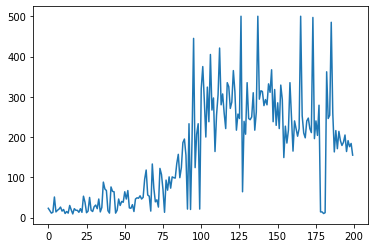

In [26]:
from tensorflow.python.util.deprecation import rewrite_argument_docstring
import matplotlib.pyplot as plt
episod_numbwer = 200
agent = Agent(env)
total_rewards = []
for i_round in range(episod_numbwer):
  state = env.reset()
  total_reward = 0
  done = False
  while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)
    agent.train(state, action, next_state, reward, done)
    state = next_state
    total_reward += reward
  total_rewards.append(total_reward)


plt.plot(total_rewards)

